Test RMSE: 470.78, Test R2: 0.3110


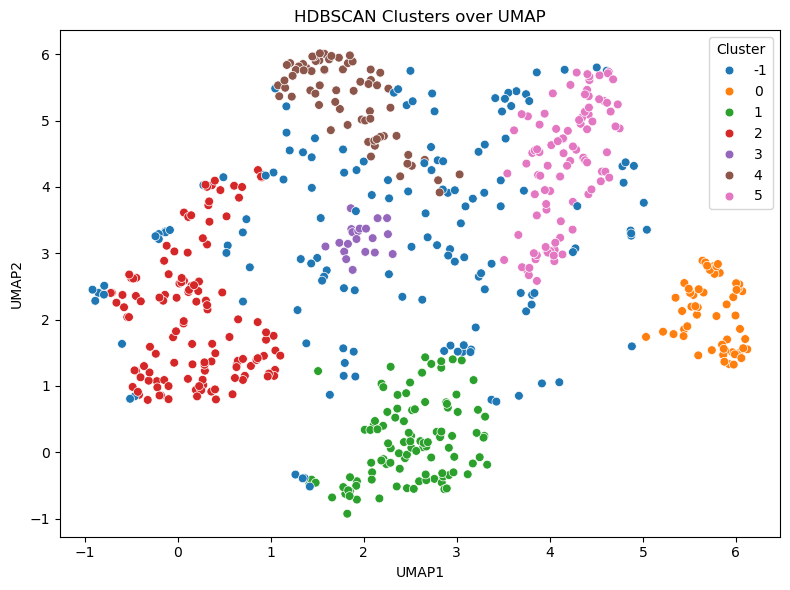

Unique HDBSCAN clusters: [-1  0  1  2  3  4  5]

OUTLIERS
Samples: 147
Mean ROS: 680.9, Median ROS: 515.0, ROS std: 560.2

Top drivers (mean SHAP with sign):
wsin10_av     7.642741
CircVar       7.095557
wco_500_av    6.823269
Recirc        4.915375
sW_7_av       4.699277
gT_9_8_av     3.437442
wsi_950_av    3.030333
wsin100_av    2.888740
aspect_cos    2.362409
wSsin_5_av    2.187137
dtype: float64

Top drivers (mean absolute SHAP ± std):
HDW_av: 87.40 ± 63.25
CircVar: 56.18 ± 38.69
wco_500_av: 40.15 ± 18.58
f_load_av: 30.02 ± 19.73
wv100_k_av: 27.65 ± 11.26
wScos_9_av: 27.29 ± 15.06
wsin10_av: 25.92 ± 17.03
rh_700_av: 24.62 ± 22.49
DC_12h_av: 24.15 ± 19.99
Recirc: 23.07 ± 20.52

Partial importance (relative within cluster):
HDW_av        0.088949
CircVar       0.057178
wco_500_av    0.040856
f_load_av     0.030552
wv100_k_av    0.028140
wScos_9_av    0.027772
wsin10_av     0.026375
rh_700_av     0.025061
DC_12h_av     0.024573
Recirc        0.023482
dtype: float64

CLUSTER 0
Samples:

In [ ]:
# =========================================================
# 0. IMPORTS
# =========================================================
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
import shap
import umap
import hdbscan
import warnings
warnings.filterwarnings('ignore')

# =========================================================
# 1. LOAD AND PREPARE DATA
# =========================================================
gdf = gpd.read_file(r"..\..\Data\Processed\PT-FireSprd_v3.0\L2_FireBehavior\PT-FireSprd_v3.0_L2_model.shp")
gdf = gdf.drop(columns=['inidoy', 'enddoy', 'ros_p_lg1', 'duration_p', 'f_start', 'geometry'])

categorical_vars = ["fuel_model", "landform", "land_use"]
for col in categorical_vars:
    gdf[col] = gdf[col].astype(str).astype("category")

y = gdf['ros_p']
X = gdf.drop(columns=['ros_p'])

# 1.1 Remove columns with >15% missing
threshold = 0.15
cols_to_keep = X.columns[X.isnull().mean() <= threshold]
X = X[cols_to_keep]

# 1.2 Impute remaining
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 1.3 One-Hot Encoding for categorical variables
X_encoded = pd.get_dummies(X_imputed, columns=[col for col in categorical_vars if col in X_imputed.columns], drop_first=True)

# 1.4 Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 1.5 Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================================================
# XGBOOST - INTERMEDIATE COMPLEX GRID
# =========================================================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0, 0.2],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
grid = GridSearchCV(xgb_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

model = grid.best_estimator_
y_pred = model.predict(X_test_scaled)
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}, Test R2: {r2_score(y_test, y_pred):.4f}")

# =========================================================
# 3. CALCULATE SHAP VALUES
# =========================================================
sample_size = min(2000, X_train_scaled.shape[0])
X_sample = X_train_scaled[:sample_size]

explainer = shap.Explainer(model, X_sample)
shap_values = explainer(X_sample)
shap_matrix = shap_values.values

# Standardize SHAP matrix
shap_matrix_scaled = StandardScaler().fit_transform(shap_matrix)

# =========================================================
# 4. CLUSTERING WITH UMAP + HDBSCAN
# =========================================================
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42, metric='cosine')
shap_umap = reducer.fit_transform(shap_matrix_scaled)

clusterer = hdbscan.HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom')
hdb_labels = clusterer.fit_predict(shap_umap)

plt.figure(figsize=(8,6))
palette = sns.color_palette('tab10', np.unique(hdb_labels[hdb_labels>=0]).max()+2)
sns.scatterplot(x=shap_umap[:,0], y=shap_umap[:,1], hue=hdb_labels, palette=palette, legend='full', s=40)
plt.title("HDBSCAN Clusters over UMAP")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

print("Unique HDBSCAN clusters:", np.unique(hdb_labels))

# =========================================================
# 5. INTERPRETATION OF CLUSTERS
# =========================================================
shap_df = pd.DataFrame(shap_matrix, columns=X_train.columns)
shap_df['cluster'] = hdb_labels
shap_df['ROS'] = y_train.iloc[:sample_size].values

for c in np.unique(hdb_labels):
    if c == -1:
        print(f"\n==============================\nOUTLIERS\n==============================")
        df_c = shap_df[shap_df['cluster']==c]
    else:
        print(f"\n==============================\nCLUSTER {c}\n==============================")
        df_c = shap_df[shap_df['cluster']==c]

    ros_mean = df_c['ROS'].mean()
    ros_median = df_c['ROS'].median()
    ros_std = df_c['ROS'].std()

    print("Samples:", len(df_c))
    print(f"Mean ROS: {ros_mean:.1f}, Median ROS: {ros_median:.1f}, ROS std: {ros_std:.1f}")
    
    print("\nTop drivers (mean SHAP with sign):")
    print(df_c.drop(columns=['cluster','ROS']).mean().sort_values(ascending=False).head(10))
    
    print("\nTop drivers (mean absolute SHAP ± std):")
    mean_abs = df_c.drop(columns=['cluster','ROS']).abs().mean()
    std_abs = df_c.drop(columns=['cluster','ROS']).abs().std()
    for f in mean_abs.sort_values(ascending=False).head(10).index:
        print(f"{f}: {mean_abs[f]:.2f} ± {std_abs[f]:.2f}")
    
    print("\nPartial importance (relative within cluster):")
    rel_imp = mean_abs / mean_abs.sum()
    print(rel_imp.sort_values(ascending=False).head(10))

print("\nANALYSIS COMPLETED")


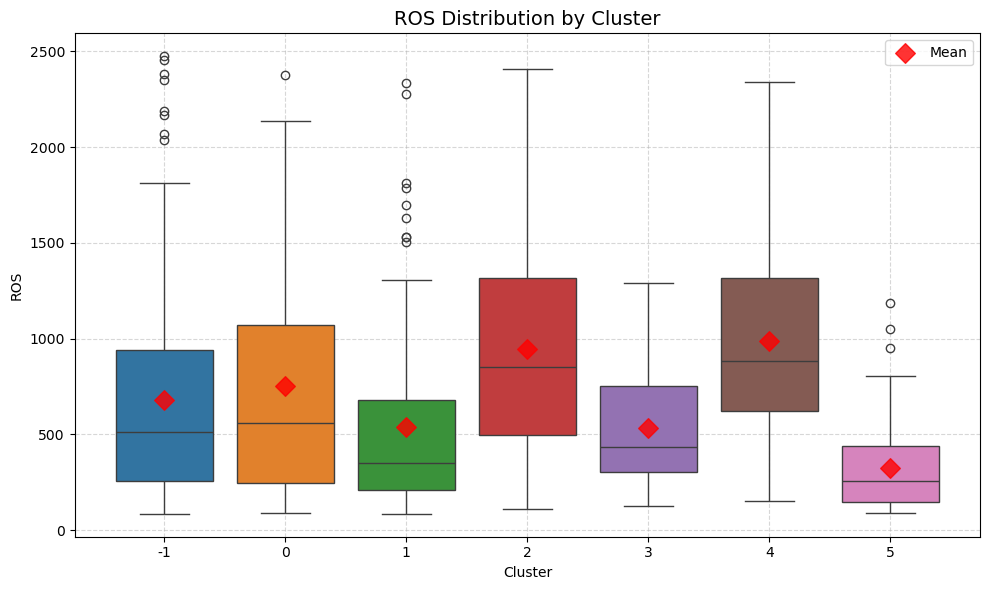

In [3]:
# =========================================================
# 7. BOXPLOT OF ROS DISTRIBUTION BY CLUSTER
# =========================================================
plt.figure(figsize=(10,6))

# Boxplot ROS por cluster com cores consistentes
sns.boxplot(x='cluster', y='ROS', data=shap_df, palette=palette)

# Calcular médias
cluster_means = shap_df.groupby('cluster')['ROS'].mean()

# Adicionar média como ponto vermelho semi-transparente, zorder alto para aparecer na frente
for i, c in enumerate(cluster_means.index):
    plt.scatter(i, cluster_means[c], color=(1,0,0,0.8), s=100, marker='D', 
                label='Mean' if i==0 else "", zorder=10)

# Adicionar gridlines
plt.grid(True, linestyle='--', alpha=0.5)

plt.title("ROS Distribution by Cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("ROS")
plt.legend()
plt.tight_layout()
plt.show()


Features selected for radar plot (importance > 0.025 in any cluster) in desired order:
['HDW_av', 'wsin10_av', 'wv100_k_av', 'wsi_950_av', 'wSv_1_av', 'wScos_9_av', 'wco_500_av', 'vwv_500_av', 'CircVar', 'Recirc', 'LiftIdx_av', 'DC_12h_av', 'rh_700_av', 'rh_300_av', 'f_load_av', '8_ny_fir_p']


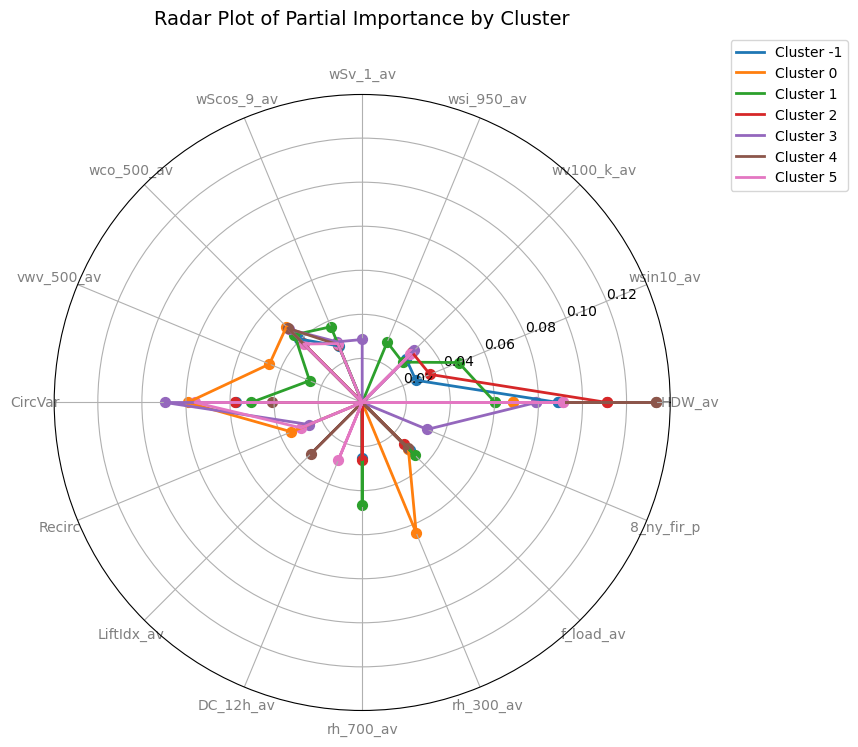

In [4]:
# =========================================================
# 6. RADAR PLOT OF CLUSTER IMPORTANCE (com paleta consistente)
# =========================================================
import matplotlib.pyplot as plt
from math import pi
import pandas as pd
import numpy as np

# 6.1 Calcular partial importance por cluster
clusters = np.unique(hdb_labels)
cluster_importances = {}

for c in clusters:
    df_c = shap_df[shap_df['cluster'] == c]
    mean_abs = df_c.drop(columns=['cluster','ROS']).abs().mean()
    rel_imp = mean_abs / mean_abs.sum()
    cluster_importances[c] = rel_imp

# 6.2 Selecionar features com importance > 0.025 em qualquer cluster
all_features = set()
for imp in cluster_importances.values():
    all_features.update(imp[imp > 0.025].index)

# Reordenar features na ordem desejada
desired_order = ['HDW_av', 'wsin10_av', 'wv100_k_av', 'wsi_950_av', 'wSv_1_av', 
                 'wScos_9_av', 'wco_500_av', 'vwv_500_av', 'CircVar', 'Recirc', 
                 'LiftIdx_av', 'DC_12h_av', 'rh_700_av', 'rh_300_av', 'f_load_av', '8_ny_fir_p']

selected_features = [f for f in desired_order if f in all_features]

print("Features selected for radar plot (importance > 0.025 in any cluster) in desired order:")
print(selected_features)

# 6.3 Preparar dataframe para radar plot
radar_df = pd.DataFrame(index=[str(c) for c in clusters], columns=selected_features).fillna(0)

for c in clusters:
    for f in selected_features:
        radar_df.loc[str(c), f] = cluster_importances[c].get(f, 0) if cluster_importances[c].get(f, 0) > 0.025 else 0

# 6.4 Mapear clusters para cores (corrigindo -1)
clusters_sorted = sorted(radar_df.index.astype(int))  # exemplo: [-1,0,1,2,3,4,5]
cluster_colors = {c: palette[i] for i, c in enumerate(clusters_sorted)}

# 6.5 Plot radar usando mesma paleta do scatterplot
num_vars = len(selected_features)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # fechar o círculo

plt.figure(figsize=(10,8))
for c in radar_df.index:
    values = radar_df.loc[c].values.flatten().tolist()
    values += values[:1]  # fechar o círculo
    plt.polar(angles, values, label=f'Cluster {c}', linewidth=2, color=cluster_colors[int(c)])
    plt.scatter(angles, values, s=50, color=cluster_colors[int(c)])

plt.xticks(angles[:-1], selected_features, color='grey', size=10)
plt.title('Radar Plot of Partial Importance by Cluster', size=14, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Preparar dados
# ------------------------------------------------------------
shap_df_int = shap_df.copy()
X_shap_int = X_shap.copy()

clusters_list = np.unique(shap_df_int["cluster"])
cluster_options = [("OUTLIERS",-1)] + [(f"CLUSTER {c}",c) for c in clusters_list if c != -1]

# Função para pegar top-10 variáveis do cluster
def top_vars(cluster, top_n=10):
    idx = shap_df_int["cluster"] == cluster
    shap_c = shap_df_int.loc[idx, X_shap_int.columns].values
    mean_abs = np.abs(shap_c).mean(axis=0)
    top_idx = np.argsort(mean_abs)[::-1][:top_n]
    return X_shap_int.columns[top_idx].tolist()

# ------------------------------------------------------------
# Função de plot interativo
# ------------------------------------------------------------
def plot_shap_biplot(cluster, variable):
    clear_output(wait=True)
    idx = shap_df_int["cluster"] == cluster
    shap_c = shap_df_int.loc[idx, X_shap_int.columns].values
    X_c = X_shap_int.loc[idx]

    var_idx = X_c.columns.get_loc(variable)
    shap_values_var = shap_c[:, var_idx]
    feature_values = X_c[variable].values

    plt.figure(figsize=(6,4))
    plt.scatter(feature_values, shap_values_var, alpha=0.6)
    plt.xlabel(f"{variable} (feature value)")
    plt.ylabel(f"SHAP value ({variable})")
    plt.title(f"Cluster {cluster} — SHAP Biplot: {variable}")
    plt.grid(True)
    plt.show()

# ------------------------------------------------------------
# Widgets
# ------------------------------------------------------------
cluster_widget = widgets.Dropdown(
    options=cluster_options,
    description='Cluster:'
)

# Atualiza variáveis do top 10 ao mudar o cluster
def update_var_widget(*args):
    cluster = cluster_widget.value
    var_widget.options = top_vars(cluster, top_n=10)

var_widget = widgets.Dropdown(description='Variable:')
cluster_widget.observe(update_var_widget, 'value')
update_var_widget()  # inicializar top-10

ui = widgets.HBox([cluster_widget, var_widget])
out = widgets.interactive_output(plot_shap_biplot, {'cluster': cluster_widget, 'variable': var_widget})

display(ui, out)


NameError: name 'X_shap' is not defined

In [12]:
from sklearn.linear_model import LinearRegression

shap_df_no_outliers = shap_df[shap_df['cluster'] != -1]  # ignorando outliers
clusters = shap_df_no_outliers['cluster'].unique()

delta_r2 = {}

for c in clusters:
    df_c = shap_df_no_outliers[shap_df_no_outliers['cluster']==c]
    X_c = df_c.drop(columns=['cluster','ROS'])
    y_c = df_c['ROS']

    # Linear regression usando apenas SHAP como features
    lr = LinearRegression()
    lr.fit(X_c, y_c)
    r2_c = lr.score(X_c, y_c)
    
    # R² global usando todas as amostras (opcional)
    lr_global = LinearRegression()
    lr_global.fit(shap_df_no_outliers.drop(columns=['cluster','ROS']), shap_df_no_outliers['ROS'])
    r2_global = lr_global.score(shap_df_no_outliers.drop(columns=['cluster','ROS']), shap_df_no_outliers['ROS'])

    delta_r2[c] = r2_c - r2_global

print("ΔR² por cluster:", delta_r2)


ΔR² por cluster: {5: 0.0665988632862895, 2: 0.058871713718391394, 1: 0.0665988632862895, 4: 0.0665988632862895, 3: 0.0665988632862895, 0: 0.0665988632862895}


In [10]:
from scipy.spatial.distance import pdist, cdist

ss_scores = {}
shap_umap_df = pd.DataFrame(shap_umap, columns=['UMAP1','UMAP2'])
shap_umap_df['cluster'] = hdb_labels

clusters = [c for c in np.unique(hdb_labels) if c != -1]  # ignorar outliers

for c in clusters:
    points = shap_umap_df[shap_umap_df['cluster']==c][['UMAP1','UMAP2']].values
    intra_dist = pdist(points).mean()
    
    other_points = shap_umap_df[shap_umap_df['cluster']!=c][['UMAP1','UMAP2']].values
    inter_dist = cdist(points, other_points).mean()
    
    ss_scores[c] = intra_dist / inter_dist

print("Structure Score por cluster:", ss_scores)


Structure Score por cluster: {0: 0.1626466856649753, 1: 0.24196413528913568, 2: 0.3502235879205861, 3: 0.1481789877360233, 4: 0.23934896150438573, 5: 0.32181184290642145}


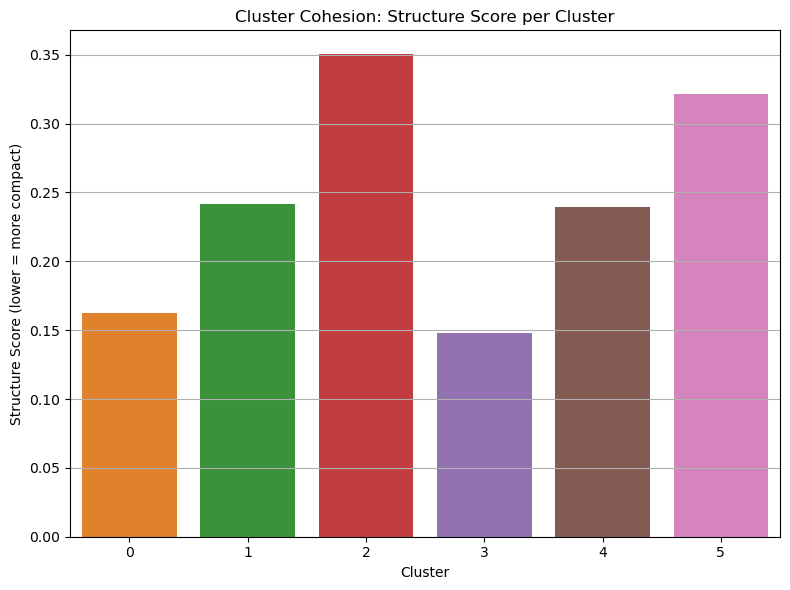

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
clusters = list(ss_scores.keys())  # cluster IDs
ss_values = [ss_scores[c] for c in clusters]

cluster_df = pd.DataFrame({
    'Cluster': clusters,
    'Structure_Score': ss_values
})

# Use a palette starting from the 2nd color
base_palette = sns.color_palette('tab10')
palette_slice = base_palette[1:] + [base_palette[0]]  # shift colors

# Plot
plt.figure(figsize=(8,6))
sns.barplot(data=cluster_df, x='Cluster', y='Structure_Score', palette=palette_slice)

plt.xlabel('Cluster')
plt.ylabel('Structure Score (lower = more compact)')
plt.title('Cluster Cohesion: Structure Score per Cluster')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
